# Sequencing

I got very excited after a talk by http://physics-astronomy.jhu.edu/directory/brice-menard/ where he presented "The Sequencer". That code is not yet open source but I wanted to play with it and thought it would be relatively easy to make a poor mans version.

To be clear, none of the ideas here are my own. They all come from Brice's talk + talking to him. This is also a pretty cool look at the power of the python ecosystem - it only takes a couple of lines of code (which hide a lot of details that I don't understand at all e.g. the Wasserstein metric) to work through a really really cool idea.

# Imports/preamble

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

In [2]:
import scipy.ndimage, scipy.stats, scipy.sparse.csgraph
import matplotlib.pyplot as plt
import pytspsa

# Load data

Load some data and shuffle it - we will try to reconstruct the original image using the sequencer.

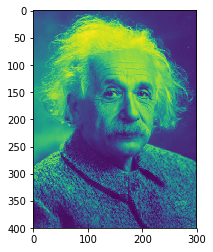

In [57]:
img = plt.imread("small_einstein.jpg")
img = np.mean(img, axis=2) # convert to B and W
plt.imshow(img)

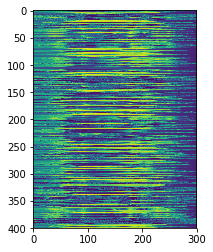

In [58]:
np.random.shuffle(img)
plt.imshow(img)

# Compute similarity matrix

In [59]:
similarity_matrix = np.zeros((len(img), len(img)), dtype=np.float32)

for i in range(len(img)):
    for j in range(len(img)):
        similarity_matrix[i][j] = scipy.stats.wasserstein_distance(img[i], img[j])

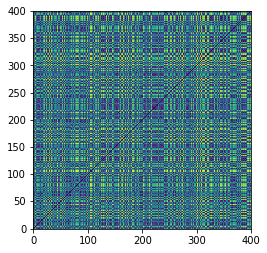

In [60]:
plt.imshow(similarity_matrix, origin="lower")

In [61]:
assert np.all(np.diagonal(similarity_matrix) == 0) # Check that diagnonal transitions are forbidden
assert np.all(similarity_matrix + np.diag(np.ones(len(img))) != 0) # Check that all other transitions are allowed

# Find the shortest route through the nodes

This is ~ the travelling salesman problem. There is one difference - we don't need to get back to our starting point. So after solving the TSP, we remove the path with the greatest cost.

In [68]:
# https://github.com/ildoonet/simulated-annealing-for-tsp
solver = pytspsa.Tsp_sa()
solver.set_num_nodes(len(similarity_matrix))
solver.add_by_distances(similarity_matrix)
solver.set_t_v_factor(54.0) # I have no idea what this does

In [69]:
solver.sa()

In [70]:
solution = solver.getBestSolution()

In [71]:
print('Path= {}'.format(solution.getRoute())) # This is the best way I could find of getting the route...

Path= 0-146-82-296-331-177-383-11-97-126-336-224-225-250-219-22-396-378-299-283-360-375-263-162-370-365-332-25-284-385-59-78-139-235-204-75-153-109-76-323-298-238-281-93-20-234-222-221-131-49-31-141-339-359-295-37-260-334-363-237-315-376-23-193-321-119-278-101-242-285-155-190-269-1-297-292-2-168-194-5-67-205-206-99-211-178-117-233-124-277-288-161-215-92-158-271-91-163-130-197-227-167-261-66-87-60-96-68-293-257-61-103-243-128-80-73-157-349-397-326-12-355-159-200-302-289-186-377-63-39-13-214-102-43-366-171-317-35-123-209-48-174-230-46-303-364-374-381-373-111-342-199-138-244-380-266-137-88-58-279-369-74-94-84-81-195-34-314-319-9-387-116-241-337-100-300-240-294-145-333-196-86-51-335-54-182-134-218-312-270-367-30-328-90-160-273-216-254-57-393-220-181-110-352-276-42-320-322-24-362-307-89-262-247-120-398-4-259-79-33-357-175-282-166-399-229-252-21-191-185-246-258-395-290-165-217-184-70-104-83-291-311-280-114-371-338-106-368-69-19-77-147-41-14-350-208-176-187-356-287-189-192-118-72-16-310-71-6-

In [79]:
route = [int(i) for i in solution.getRoute().split("-")]
cost = []
for i in range(len(route) - 1):
    cost.append(similarity_matrix[route[i]][route[i]-1])
cost = np.array(cost)
cut = np.where(cost == np.max(cost))[0][0]
route = route[cut:] + route[:cut]

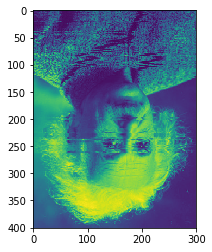

In [80]:
plt.imshow(img[route])

* Einstein ends up upside down which I don't think is actually an issue - this just means that we have sequenced in reverse which is fine as most things you would actually use this for don't have an obvious ordering. (I'll put him right way up just to feel good about myself)
* We get a couple of things out of order. But it isn't terrible! Not great, but not terrible...
* There is also a bit of manual tuning I had to do to do this. Mostly around the TV param in the TSP. Which I still don't understand.

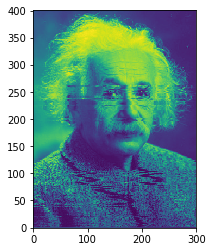

In [81]:
plt.imshow(img[route], origin="lower")